## Importing Data and Libraries

In [711]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfume.Clustering import Clusterer
from pyfume.EstimateAntecendentSet import AntecedentEstimator
from pyfume.EstimateConsequentParameters import ConsequentEstimator
from pyfume.SimpfulModelBuilder import SugenoFISBuilder
from pyfume.Tester import SugenoFISTester
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score
from numpy import clip, column_stack, argmax
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [712]:
Train = pd.read_csv('dataTrain.csv')
Test = pd.read_csv('dataTest.csv')

stats = pd.read_csv('stats.csv')
stats = stats.iloc[:,1:]

X_train = Train.drop('output', axis=1)
y_train = Train['output']

X_test = Test.drop('output', axis=1)
y_test = Test['output']

maxs = X_train.max().tolist()
mins = X_train.min().tolist()

var_names = X_train.columns.to_list()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((241, 12), (61, 12), (241,), (61,))

In [713]:
stats

,Feature,Mean,Variance
0,age,54.373444,83.926930
1,sex,0.651452,0.227062
2,cp,1.000000,1.070539
3,trtbps,130.784232,275.936847
4,chol,245.033195,2254.206367
5,fbs,0.132780,0.115150
6,restecg,0.526971,0.282468
7,thalachh,149.759336,495.798927
8,exng,0.302905,0.211153
9,oldpeak,0.978423,1.099368


In [714]:
savecols = X_train.columns

In [715]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.array
y_test = y_test.array

## Building the model

### Clustering

In this section, we will try out different numbers of clusters in order to minimize the separation between clusters. 

#### Functions

In [716]:
def SeparationMetric(X_train, clust_centers, part_matrix):
    metric = 0
    for clust in range(clust_centers.shape[0]):
        for point in range(X_train.shape[0]):
            metric += part_matrix[point, clust] * distance.euclidean(X_train[point], clust_centers[clust])
    return metric

In [717]:
def gaussian(x, mu, sig, mux, sigx):
    mu = mux + sigx * mu
    sig = sig * sigx
    #return (1.0 / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2))
    return (np.exp(-np.power((x - mu) / sig, 2.0) / 2))

In [718]:
def Revert(x, stats):
    for i in range(x.shape[0]):
        data = stats[stats['Feature'] == savecols[i]]
        x[i] = x[i] * (data.iloc[0,2] ** 0.5) + data.iloc[0,1]
    return x

#### Code

In [719]:
max_clusters = 10
min_metric = np.inf
selected_method = 'fst-pso' #'gk'
""""
for i in range(max_clusters):
    i += 1
    #clust_centers, part_matrix = Cluster(i)
    cl = Clusterer(x_train=X_train, y_train=y_train, nr_clus=i)
    clust_centers, part_matrix, _ = cl.cluster(method=selected_method)
    clust_centers = clust_centers[:,:-1]
    
    metric = SeparationMetric(X_train, clust_centers, part_matrix)
    if metric < min_metric:
        min_metric = metric
        best_number = i

print(f'Best number of clusters: {best_number}')"""

'"\nfor i in range(max_clusters):\n    i += 1\n    #clust_centers, part_matrix = Cluster(i)\n    cl = Clusterer(x_train=X_train, y_train=y_train, nr_clus=i)\n    clust_centers, part_matrix, _ = cl.cluster(method=selected_method)\n    clust_centers = clust_centers[:,:-1]\n    \n    metric = SeparationMetric(X_train, clust_centers, part_matrix)\n    if metric < min_metric:\n        min_metric = metric\n        best_number = i\n\nprint(f\'Best number of clusters: {best_number}\')'

In [720]:
best_number = 2   # TIRAR

#clust_centers, part_matrix = Cluster(best_number)
cl = Clusterer(x_train=X_train, y_train=y_train, nr_clus = best_number)
clust_centers, part_matrix, _ = cl.cluster(method=selected_method, m = 0.99)
clust_centers = clust_centers[:,:-1]
clust_centers.shape, part_matrix.shape

Fuzzy Self-Tuning PSO - v1.8.1
 * Max distance: 18.910044
 * Search space boundaries set to: [[-1.3671311638052943, 0.7314587118448709], [-1.3671311638052943, 0.7314587118448709], [-0.9664929007146316, 1.9329858014292631], [-0.9664929007146316, 1.9329858014292631], [-2.2144039565795786, 2.3607819282158617], [-2.2144039565795786, 2.3607819282158617], [-2.401786816576483, 2.568885877536174], [-2.401786816576483, 2.568885877536174], [-0.3912927904356147, 2.555631037532609], [-0.3912927904356147, 2.555631037532609], [-0.9915220285980402, 2.771577324033892], [-0.9915220285980402, 2.771577324033892], [-2.5715413778467515, 2.3461506537983703], [-2.5715413778467515, 2.3461506537983703], [-0.6591841999955774, 1.5170266520446165], [-0.6591841999955774, 1.5170266520446165], [-0.9331578631464132, 2.8817877690552076], [-0.9331578631464132, 2.8817877690552076], [-2.334849818633804, 0.965436435270869], [-2.334849818633804, 0.965436435270869], [-0.6834895479753919, 3.3836951696065687], [-0.68348954797

((2, 12), (241, 2))

In [721]:
pd.DataFrame(clust_centers, columns=savecols)

,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,-0.242517,0.047133,-0.090933,-0.145979,0.07137,0.005472,0.118012,0.055978,-0.027430,-0.030415,0.143662,-0.021989
1,-0.275749,0.032489,-0.047298,-0.156637,0.11345,-0.020877,0.154137,0.065995,-0.029209,-0.006518,0.094282,-0.038844


### Building the model

In [722]:
ae = AntecedentEstimator(X_train, part_matrix)
antecedent_params = ae.determineMF()

ce = ConsequentEstimator(X_train, y_train, part_matrix)
conseq_params = ce.suglms()

modbuilder = SugenoFISBuilder(antecedent_params, conseq_params, var_names, save_simpful_code=False)
model = modbuilder.get_model()

 * Detected 2 rules / clusters
 * Detected Sugeno model type


### Inference and Metrics

In [723]:
modtester = SugenoFISTester(model, X_test, var_names)
y_pred_probs = clip(modtester.predict()[0], 0, 1)
a = y_pred_probs
y_pred_probs = column_stack((1 - y_pred_probs, y_pred_probs))
y_pred = argmax(y_pred_probs,axis=1)

In [724]:
acc_score = accuracy_score(y_test, y_pred)
print("Accuracy: {:.3f}".format(acc_score))
rec_score = recall_score(y_test, y_pred)
print("Recall: {:.3f}".format(rec_score))
prec_score = precision_score(y_test, y_pred)
print("Precision Score: {:.3f}".format(prec_score))
F1_score = f1_score(y_test, y_pred)
print("F1-Score: {:.3f}".format(F1_score))
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa Score: {:.3f}".format(kappa))

Accuracy: 0.836
Recall: 0.844
Precision Score: 0.844
F1-Score: 0.844
Kappa Score: 0.671


## Model Visualization/Interpretation

In [725]:
model._outputfunctions

OrderedDict([('fun1',
              '-1.054937e-01*sex+7.357401e-02*cp+-2.946063e-02*trtbps+-4.339897e-02*chol+3.832253e-02*fbs+1.457441e-02*restecg+7.586023e-02*thalachh+-9.091621e-02*exng+-2.350526e-02*oldpeak+8.823439e-02*slp+-1.638751e-01*caa+-9.176293e-02*thall+5.009747e-01'),
             ('fun2',
              '-1.143505e-01*sex+9.173030e-02*cp+-4.986847e-02*trtbps+-1.191095e-02*chol+3.622047e-02*fbs+3.176082e-02*restecg+6.915530e-02*thalachh+-4.924064e-02*exng+-8.957764e-02*oldpeak+5.119184e-02*slp+-8.554053e-02*caa+-8.553303e-02*thall+5.732566e-01')])

In [726]:
model._lvs['chol'] # example of how pyFUME defines une linguistic variable in simpful

<Linguistic variable 'chol', contains fuzzy sets [<Fuzzy set (function), term='cluster1'>, <Fuzzy set (function), term='cluster2'>], universe of discourse: None>

In [727]:
# The pyFUME library doesn't atribute a universe of discourse to the linguistic variables it creates in simpful. In order to fix this, we set each universe considering the maximum
# value heald by each dataframe column. This has to be done since, otherwise, the plotting functions won't work.

for ix in range(len(var_names)):
    max = maxs[ix]
    min = mins[ix]
    uod = [min, max]
    model._lvs[var_names[ix]]._universe_of_discourse = uod

In [728]:
model._rules

[[f.(c.(sex IS cluster1) AND f.(c.(cp IS cluster1) AND f.(c.(trtbps IS cluster1) AND f.(c.(chol IS cluster1) AND f.(c.(fbs IS cluster1) AND f.(c.(restecg IS cluster1) AND f.(c.(thalachh IS cluster1) AND f.(c.(exng IS cluster1) AND f.(c.(oldpeak IS cluster1) AND f.(c.(slp IS cluster1) AND f.(c.(caa IS cluster1) AND c.(thall IS cluster1)))))))))))),
  ('OUTPUT', 'fun1')],
 [f.(c.(sex IS cluster2) AND f.(c.(cp IS cluster2) AND f.(c.(trtbps IS cluster2) AND f.(c.(chol IS cluster2) AND f.(c.(fbs IS cluster2) AND f.(c.(restecg IS cluster2) AND f.(c.(thalachh IS cluster2) AND f.(c.(exng IS cluster2) AND f.(c.(oldpeak IS cluster2) AND f.(c.(slp IS cluster2) AND f.(c.(caa IS cluster2) AND c.(thall IS cluster2)))))))))))),
  ('OUTPUT', 'fun2')]]

In [729]:
#model.produce_figure("",2)

## Converting the model to X

#### More functions

In [730]:
def UODtoX(model, stats):
    uods = {}
    for lv in model._lvs:
        data = stats[stats['Feature'] == lv]
        mean = data.iloc[0,1]
        std = data.iloc[0,2] ** 0.5
        uod = model._lvs[lv]._universe_of_discourse
        for i in range(2):
            uod[i] = uod[i] * std + mean
        uods[lv] = uod
    return uods

In [731]:
class XMF:

    def __init__(self, uod, data, mu, sigma):
        self.uod = uod
        self.mean = data.iloc[0,1]
        self.std = data.iloc[0,2] ** 0.5
        self.mu = mu
        self.sigma = sigma

    def __call__(self, x):
        #x = (x - self.mean) / self.std # X to Z
        x = gaussian(x, self.mu, self.sigma, self.mean, self.std) # Z to MF
        
        return x

In [732]:
def newMFS(model, stats, uods):
    MFS = {}
    for lv in model._lvs:
        fs = []
        data = stats[stats['Feature'] == lv]
        uod = uods[lv]
        for clust in range(len(model._lvs[lv]._FSlist)):
            mu = model._lvs[lv]._FSlist[clust]._funpointer._mu
            sigma = model._lvs[lv]._FSlist[clust]._funpointer._sigma
            fs.append(XMF(uod, data, mu, sigma))
        MFS[lv] = fs
    return MFS

In [733]:
def plotMFs(mfs, var):
    mfs = mfs[var]
    x = np.linspace(mfs[0].uod[0], mfs[0].uod[1], 100)
    for i in range(len(mfs)):
        y = [mfs[i](j) for j in x]
        plt.plot(x, y)

In [734]:
def FunctionstoX(model, stats):
    final_df = pd.DataFrame(columns = var_names+['constant'])

    for f in model._outputfunctions:
        acumulated = 0 # value to be added to the intercept in the end
        expression = model._outputfunctions[f]
        item_list = expression.split('+')

        for k in range(len(item_list) - 1):
            item_list[k] = item_list[k].split('*')
            values = stats[stats['Feature'] == item_list[k][1]]
            std = values.iloc[0,2] ** 0.5
            mean = values.iloc[0,1]
            acumulated -= float(item_list[k][0]) * mean / (std) 
            item_list[k] = float(item_list[k][0]) / (std) 
            
        item_list[-1] = float(item_list[-1]) + acumulated
        final_df = pd.concat([final_df,pd.DataFrame([item_list], columns = var_names+['constant'])], axis = 0)
        final_df.reset_index(drop=True, inplace=True)
    return final_df

In [735]:
"""
def inference(X_test, mfs, consequents):
    X = X_test.copy()
    for i in range(best_number):
        X[i] = Revert(X[i], stats)
    y = [] # dim 1: weighted sum of the consequents for each cluster
    dim = X.shape[1]
    for i in range(X.shape[0]):
        membership_list = [] # member ship values for a certain observation. dim 1: var, dim 2: clust
        for k in range(dim):
            temp_list = [] # membership values for a certain variable. dim 1: clust
            for clust in range(best_number):
                temp_list.append(mfs[var_names[k]][clust](X[i,k]))
            membership_list.append(temp_list)
        acumulated = 0
        for h in range(best_number):
            for j in range(dim):
                acumulated += membership_list[j][h] * consequents.iloc[h,j] * X[i,j]
            acumulated += consequents.iloc[h,-1]
        y.append(acumulated)

    return np.array(y) # dim 1: observationm dim 2: clust"""

'\ndef inference(X_test, mfs, consequents):\n    X = X_test.copy()\n    for i in range(best_number):\n        X[i] = Revert(X[i], stats)\n    y = [] # dim 1: weighted sum of the consequents for each cluster\n    dim = X.shape[1]\n    for i in range(X.shape[0]):\n        membership_list = [] # member ship values for a certain observation. dim 1: var, dim 2: clust\n        for k in range(dim):\n            temp_list = [] # membership values for a certain variable. dim 1: clust\n            for clust in range(best_number):\n                temp_list.append(mfs[var_names[k]][clust](X[i,k]))\n            membership_list.append(temp_list)\n        acumulated = 0\n        for h in range(best_number):\n            for j in range(dim):\n                acumulated += membership_list[j][h] * consequents.iloc[h,j] * X[i,j]\n            acumulated += consequents.iloc[h,-1]\n        y.append(acumulated)\n\n    return np.array(y) # dim 1: observationm dim 2: clust'

In [736]:
def inference(X_test, mfs, consequents):
    X = X_test.copy()
    for i in range(best_number):
        X[i] = Revert(X[i], stats)
    y = [] # dim 1: weighted sum of the consequents for each cluster
    dim = X.shape[1]
    for i in range(X.shape[0]):
        membership_list = []
        for k in range(dim):
            temp_list = [] # membership values for a certain variable. dim 1: clust
            for clust in range(best_number):
                temp_list.append(mfs[var_names[k]][clust](X[i,k]))
            membership_list.append(temp_list)
        membership_list = np.transpose(np.array(membership_list)) # membership values for a certain observation. dim 1: clust, dim 2: var
        acumulated = 0
        firing_strengths = 0
        for h in range(best_number):
            linear_sum = 0
            for j in range(dim):
                linear_sum += consequents.iloc[h,j] * X[i,j]
            linear_sum += consequents.iloc[h,-1] # output of the linear function of cluster h
            acumulated += linear_sum * np.min(membership_list[h]) 
            firing_strengths += np.min(membership_list[h])
        acumulated = np.array(acumulated) / firing_strengths
        y.append(acumulated.tolist())

    return np.array(y) # dim 1: observation

#### Code

In [737]:
uods = UODtoX(model, stats)
mfs = newMFS(model, stats, uods)
consequents = FunctionstoX(model, stats)
#uods

In [738]:
for i in range(best_number):
    clust_centers[i] = Revert(clust_centers[i], stats)
clust_centers = pd.DataFrame(clust_centers, columns = var_names)
clust_centers

,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,0.535891,1.048767,129.273718,238.102339,0.156998,0.529879,152.387061,0.328627,0.949663,1.396506,0.813488,2.310611
1,0.520055,1.033615,129.998552,237.596319,0.171278,0.515875,153.191439,0.333230,0.947798,1.410988,0.764924,2.300616


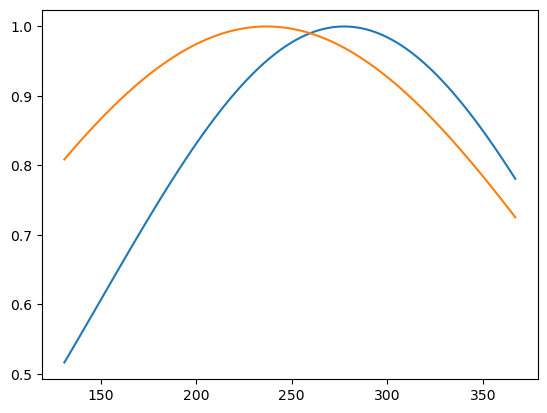

In [739]:
plotMFs(mfs, 'chol')

In [740]:
consequents

,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,constant
0,-0.221388,0.071109,-0.001774,-0.000914,0.112934,0.027422,0.003407,-0.197853,-0.022418,0.145599,-0.166628,-0.154736,0.837765
1,-0.239975,0.088657,-0.003002,-0.000251,0.106739,0.059760,0.003106,-0.107158,-0.085433,0.084474,-0.086977,-0.144231,0.974374


In [741]:
inference(X_test, mfs, consequents)

array([-0.05434218,  0.24598495,  1.22133428,  0.71628398,  1.87512832,
        1.1408093 ,  1.08310356,  0.13883983,  0.14658059,  0.72292305,
        1.15679046,  0.38514643,  1.16636618,  0.61739554,  1.68481364,
        1.15729598,  1.63229421, -0.06907483,  0.11050245,  0.2117895 ,
        0.79261867,  0.3789787 ,  0.86199573,  1.4492678 ,  1.49476846,
        0.84879993,  0.04685108,  0.73709651,  0.1756783 ,  1.49113131,
        0.3285997 ,  0.24577786,  0.99818704,  0.36271099,  1.34107867,
        0.27159485,  1.14349362,  1.38927858,  0.74408003,  0.99406418,
        0.87656726,  0.92463289,  1.38624287,  0.85702022,  0.93710125,
        1.31893547,  1.3138726 ,  1.49890918,  1.23062961,  0.16714384,
        0.49669836, -0.08229486,  1.26958229,  1.67078505,  0.30946521,
        0.50097556, -0.15171625,  1.2635008 ,  0.56199655,  0.77819382,
        0.89359185])

In [742]:
a

array([0.        , 0.24598495, 0.76467843, 0.10508404, 0.98962912,
       0.83228189, 0.59169818, 0.        , 0.        , 0.42766811,
       0.69895176, 0.16896462, 0.80132394, 0.23544859, 1.        ,
       0.88283876, 1.        , 0.        , 0.        , 0.        ,
       0.51606149, 0.        , 0.36048288, 0.64432578, 0.85158342,
       0.59994204, 0.        , 0.56734333, 0.        , 0.94530168,
       0.        , 0.06977127, 0.57887775, 0.28494574, 0.63172849,
       0.06876465, 0.73333776, 0.78344838, 0.64069411, 0.78336528,
       0.45396162, 0.64658782, 0.82602537, 0.65766974, 0.70236615,
       0.25309744, 0.81731832, 1.        , 0.35705635, 0.        ,
       0.        , 0.        , 0.75247676, 1.        , 0.06913044,
       0.28757104, 0.        , 0.91848686, 0.06120276, 0.54584354,
       0.54686555])

In [743]:
X_test[0]

array([ 0.73145871, -0.9664929 ,  0.07318899,  2.27401546, -0.39129279,
        0.89002765, -0.79757941,  1.51702665,  0.21132583, -0.68470669,
        0.33330663,  1.14050171])